<a href="https://colab.research.google.com/github/lagonee23/price-prediction-models/blob/main/bitcoin_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 암호화폐(BitCoin)의 가격 예측 모델


### 필요 모듈 설치
> [pyupbit](https://github.com/sharebook-kr/pyupbit) 모듈은 업비트라는 암호화폐 거래소의 API를 파이썬에서 쉽게 사용하기 위해 개발되었습니다.
해당 라이브러리를 통해 암호화폐의 현재 가격, 매매 주문 등의 정보를 쉽게 얻어올 수 있습니다.

In [2]:
!pip install pyupbit
!pip3 install xgboost
!pip3 install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 1.7 MB/s eta 0:00:00


In [3]:
import pyupbit

### 업비트에서 일봉(day)차트의 데이터 가져오기
* `open`: 시가
* `high`: 고가
* `low`: 저가
* `close`: 종가
* `volume`: 거래량
* `value`: 거래대금

> 업비트는 한국 거래소이므로 데이터의 단위는 원화(￦)입니다.

In [16]:
# UpBit에서 비트코인 가격 데이터 가져오기
df_origin = pyupbit.get_ohlcv("KRW-BTC", "day", count=2500, period=1)
df_origin

,open,high,low,close,volume,value
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...
2023-12-01 09:00:00,50601000.0,52000000.0,50500000.0,51709000.0,4022.039333,2.066847e+11
2023-12-02 09:00:00,51710000.0,52833000.0,51645000.0,52603000.0,2689.116908,1.399282e+11
2023-12-03 09:00:00,52615000.0,53864000.0,52531000.0,53700000.0,3551.854502,1.884204e+11
2023-12-04 09:00:00,53761000.0,57337000.0,53690000.0,56920000.0,11395.027520,6.349280e+11


### 기준모델 설정
**기준 모델(Baseline Model)**은 예측 문제를 해결하기 위해 설정하는 단순한 모델이나 기준을 의미합니다. 이 모델은 일반적으로 복잡한 머신러닝 모델을 사용하기 전에, 문제를 얼마나 잘 이해하고 있는지, 어떤 방식으로 접근해야하는지를 판단하는 데 도움을 줍니다.

본 프로젝트에서는 타겟 변수의 **평균값**으로 기준모델을 설정합니다.



In [32]:
import numpy as np

df = df_origin.copy()  # 원본복사

predict = df['close'].mean()  # 평균값
print('Baseline model:', np.around(predict))

Baseline model: 25898786.0


### 시각화
비트코인 가격의 데이터와 기준 모델을 선차트로 표현합니다.

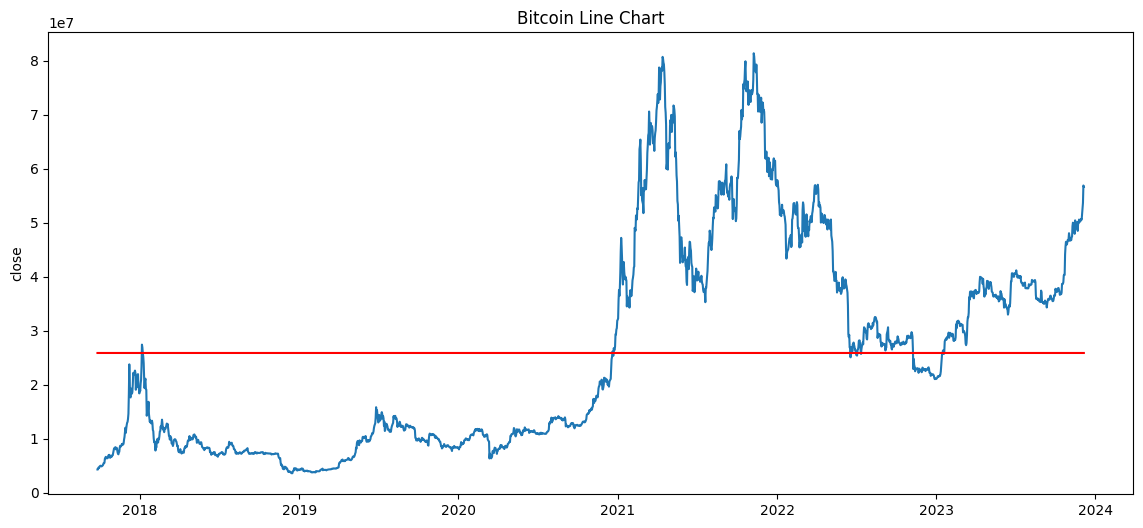

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x=df.index, y='close')  # 비트코인 차트
sns.lineplot(x=df.index, y=predict, color='r')  # 기준모델
plt.title('Bitcoin Line Chart')
plt.show()

### EDA, Feature engineering
* 새로운 컬럼을 생성
  * `candle`: 전날 대비 캔들의 비율(음봉은 음수, 양봉은 양수)
  * `volume_ratio`: 전날 대비 거래량의 비율
  * `profit_loss`: 다음 날의 손실(0)과 이득(1)을 나타내는 컬럼을 생성

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = df_origin.copy()

# 전날 대비 캔들의 길이
candle_lst = [np.nan]
for c in range(len(df)-1):
  candle_ratio = (df['close'].iloc[c+1]-df['open'].iloc[c+1]) / abs(df['close'].iloc[c]-df['open'].iloc[c]+1)
  candle_lst.append(candle_ratio.round(2))

df['candle'] = candle_lst


# 전날 대비 거래량 비율
volume_lst = [np.nan]
for c in range(len(df)-1):
  volume_ratio = df['volume'].iloc[c+1] / df['volume'].iloc[c]
  volume_lst.append(volume_ratio.round(2))

df['volume_ratio'] = volume_lst


# 다음날의 손익 컬럼 생성(1은 수익, 0은 손실을 의미)
pl_lst = []
for p in range(len(df)-1):
  if df.iloc[p+1, 3]-df.iloc[p+1,0] > 0:
    pl_lst.append(1)
  elif df.iloc[p+1,3]-df.iloc[p+1,0] <= 0:
    pl_lst.append(0)
# 마지막 행의 손익을 알 수 없으므로 결측치 처리
pl_lst.append(np.nan)
df['profit_loss'] = pl_lst

# 첫 행과 마지막 행 삭제
df.dropna(inplace=True)

# 데이터 타입 변경
df = df.astype({'open':int, 'high':int, 'low':int, 'close':int, 'profit_loss':int})
df

,open,high,low,close,volume,value,candle,volume_ratio,profit_loss
2018-06-16 09:00:00,7180000,7336000,7116000,7277000,2031.228609,1.466238e+10,0.53,0.62,0
2018-06-17 09:00:00,7275000,7329000,7206000,7218000,1502.422928,1.092767e+10,-0.59,0.74,1
2018-06-18 09:00:00,7231000,7550000,7135000,7461000,3050.852968,2.228546e+10,4.04,2.03,1
2018-06-19 09:00:00,7461000,7649000,7370000,7553000,3830.012509,2.880468e+10,0.40,1.26,0
2018-06-20 09:00:00,7553000,7594000,7110000,7538000,5808.173132,4.256953e+10,-0.16,1.52,0
...,...,...,...,...,...,...,...,...,...
2023-11-30 09:00:00,50720000,50963000,50445000,50586000,2773.480739,1.404988e+11,-0.93,0.98,1
2023-12-01 09:00:00,50601000,52000000,50500000,51709000,4022.039333,2.066847e+11,8.27,1.45,1
2023-12-02 09:00:00,51710000,52833000,51645000,52603000,2689.116908,1.399282e+11,0.81,0.67,1
2023-12-03 09:00:00,52615000,53864000,52531000,53700000,3551.854502,1.884204e+11,1.22,1.32,1


### 특성과 타겟을 분리, 학습과 테스트 데이터를 분리

In [6]:
from sklearn.model_selection import train_test_split

features = ['candle',	'volume_ratio']
target = 'profit_loss'

X, y = df[features], df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 데이터 정규화 및 기준모델의 정확도 계산

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Scaling
scaler_std = StandardScaler()

X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)


# 기준모델
base = y_train.mode()[0]
baseline = len(y_train) * [base]
y_pred_base = len(y_test) * [base]
# 기준모델의 정확도
print("Train accuracy:", accuracy_score(y_train, baseline).round(3))
print("Test accuracy:", accuracy_score(y_test, y_pred_base).round(3))

Train accuracy: 0.516
Test accuracy: 0.515


### 기준모델의 Confusion Matrix

In [8]:
y_true0 = y_test.value_counts()[0]
y_true1 = y_test.value_counts()[1]
confusion_base = pd.DataFrame(index = ['True 0', 'True 1'], data = {'Predicted 0':[0,0], 'Predicted 1':[y_true0,y_true1]})
confusion_base

,Predicted 0,Predicted 1
True 0,0,194
True 1,0,206


## 로지스틱 모델

### 모델의 정확도

In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

# 로지스틱 회귀
logCV_model = LogisticRegressionCV(cv=5)
logCV_model.fit(X_train_std, y_train)

# 로지스틱 회귀모델의 정확도
print("Train accuracy:", logCV_model.score(X_train_std, y_train).round(3))

Train accuracy: 0.518


### 평가지표

In [10]:
from sklearn.metrics import classification_report

y_pred_test_log = logCV_model.predict(X_test_std)

print(classification_report(y_test, y_pred_test_log))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       194
           1       0.52      1.00      0.68       206

    accuracy                           0.52       400
   macro avg       0.26      0.50      0.34       400
weighted avg       0.27      0.52      0.35       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 랜덤포레스트 모델

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(oob_score=True, n_jobs=-1)
rf_model.fit(X_train, y_train)

print("Train accuracy:", rf_model.score(X_train, y_train).round(3))
print("Out-of-bag 샘플의 정확도:", rf_model.oob_score_.round(3))

Train accuracy: 0.995
Out-of-bag 샘플의 정확도: 0.521


In [12]:
y_pred_test_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.47      0.47      0.47       194
           1       0.50      0.50      0.50       206

    accuracy                           0.49       400
   macro avg       0.49      0.49      0.49       400
weighted avg       0.49      0.49      0.49       400



## XGBoost

In [13]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    eval_metric="error",
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    learning_rate=0.1,
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train)

# 정확도
print("Traing accuracy", xgb_model.score(X_train, y_train).round(3))

y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

Traing accuracy 0.842
              precision    recall  f1-score   support

           0       0.46      0.46      0.46       194
           1       0.50      0.50      0.50       206

    accuracy                           0.48       400
   macro avg       0.48      0.48      0.48       400
weighted avg       0.48      0.48      0.48       400

